Christian Arendt Rasmussen s144466, Frederikke Lehmann s154109 & Clara Foss s154312

# Prediction of music track popularity using hierarchical regression

For the purpose of this project in the course 42186 Model-based machine learning F19 , we have chosen to work with data from Spotify. We have extracted the data ourselves using the Spotipy Python library inspired by the Kaggle data set (https://www.kaggle.com/nadintamer/top-tracks-of-2017/version/1). We have around 13200 observations, consisting of random tracks from the genres "pop", "metal", "classical" and "rap", respectively. Each song has a set of audio features, including popularity danceability, energy, tempo, key, etc., and this leads us to our research question:

### Research question
How can the popularity of a Spotify track be predicted with hierarchical regression using the observed audio features, with genre as the level, and how does this compare with a simpler baseline model?

#### Importing packages

In [6]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
import pystan
import pystan_utils
from sklearn.utils import shuffle
np.random.seed(42)
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (6, 4)
from IPython.display import Image
import seaborn as sns

#### Loading data
I  this section the data set will be loaded and in the below figures you will gain knowledge about the dataset and its variables. Furthermore, you will see how many spotify tracks are within each genre.

In [7]:
df = pd.read_csv("genredata2.csv")
df.head()

,Unnamed: 0,Unnamed: 0.1,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,genre
0,485,485,Soolking,Vroom vroom,6Y4h3C3S6J1l3mlH4IgcZk,65,0.265000,0.794,177493,0.872,0.000000,2,0.1970,-4.285,1,0.0692,99.968,4,0.524,4
1,100,100,Godsmack,When Legends Rise,367RiGuLVLO3DTer4NuRLJ,57,0.000293,0.428,172826,0.914,0.000013,4,0.0869,-4.273,0,0.2810,124.115,4,0.468,2
2,4037,4037,Paul Gilbert,Fuzz Universe,1pxPtN4qoMvX8KmGscOxYr,37,0.001980,0.325,423453,0.945,0.412000,6,0.3470,-5.331,0,0.0519,131.923,4,0.372,3
3,4417,4417,Bloodbound,Moria,5CtKdgmm86gjAETNUqDJHQ,49,0.000554,0.493,340622,0.963,0.000036,8,0.0910,-5.421,1,0.1770,75.020,4,0.199,3
4,2631,2631,Katinka,Før Jeg Mødte Dig,1t4nON7nEOskoxzNqBRf6t,28,0.323000,0.476,269997,0.524,0.000003,7,0.2540,-7.600,1,0.0344,119.836,4,0.301,1


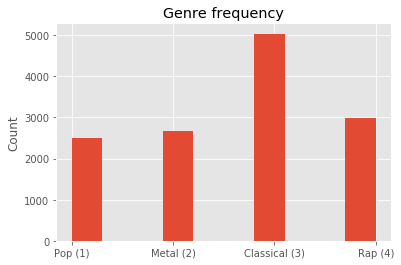

In [8]:
plt.hist(df['genre'])
plt.ylabel('Count')
plt.title('Genre frequency')
plt.xticks(np.arange(1,5,step=1),["Pop (1)","Metal (2)","Classical (3)","Rap (4)"])
plt.show()

In [9]:
# The size of the data set
df.shape

(13200, 20)

#### Data preparation
This section will prepare the data e.g. dealing with irrelevant columns, then the data will be divided, such that popularity and genre is separated from the audio feature variables. Lastly, the data for each of the audio features are standardized in order to account for variance in the data.

In [10]:
#df = df[:200]
# separate between features/inputs (X) and target/output variables (y)
mat = df.drop(['Unnamed: 0','Unnamed: 0.1','artist_name','track_name','track_id'],axis = 1)
mat = mat.values

X = mat[:,1:-1].astype("float")
y = mat[:,0].astype("int")
ind = mat[:,-1].astype("int")

# standardize input features
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

y_mean = y.mean()
y_std = y.std()

# First, let's gain some knowledge about the dataset and its distribution

# 1) KDE of audio features 

##### We have illustrated the distribution of each audio feature.
Below, we see that danceability, energy, loudness follow a Gaussian distribution with left-skew. Speechiness and duration follow a Gaussian distribution with right-skew. Tempo is likely to follow a mixture of Gaussians. Notice, the distribution for 'popularity' where a lot of observations equals '0' and which results in a "peak" in the distribution.  

C:\Users\Christian\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Christian\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Christian\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Christian\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Christian\Anaconda3\lib\site-packages\matpl

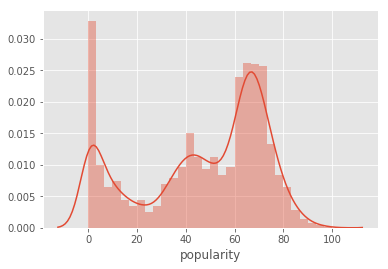

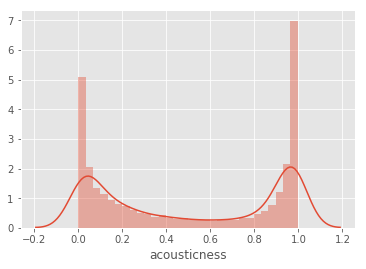

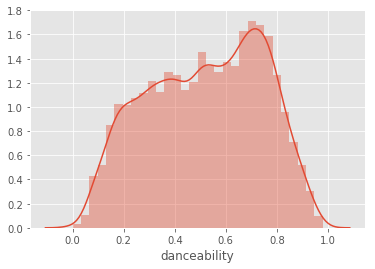

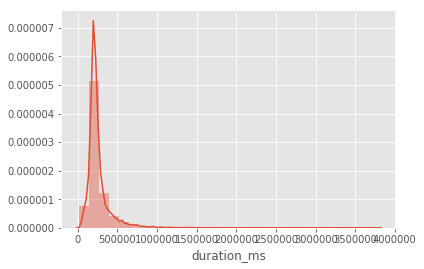

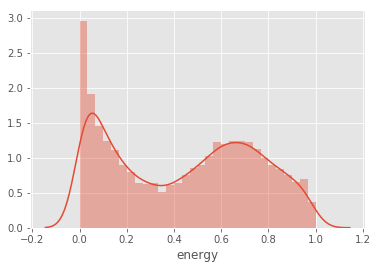

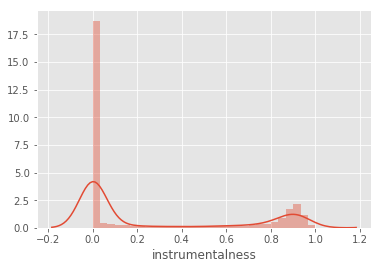

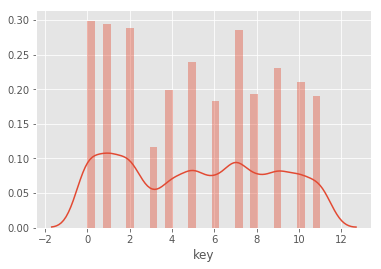

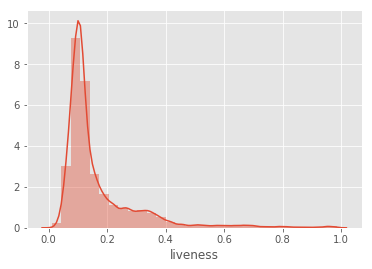

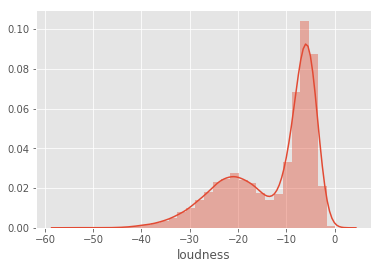

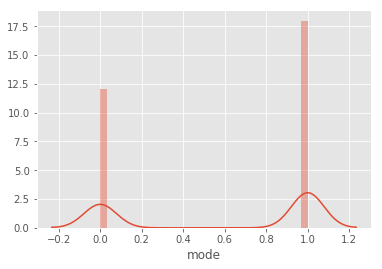

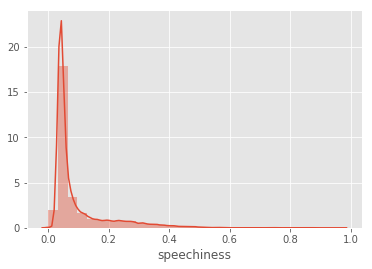

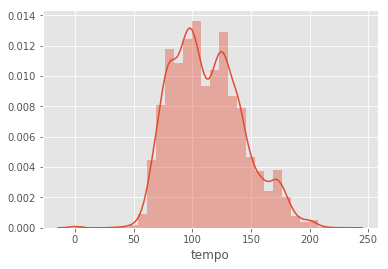

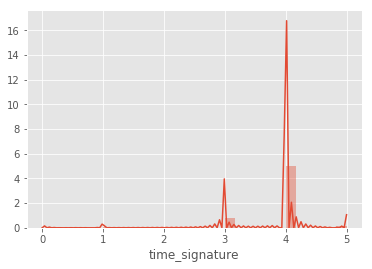

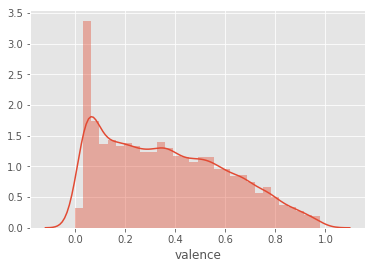

In [14]:
features = df.columns[5:-1]

#cnt = 0
for i in features: 
    plt.figure()
    sns.distplot(df[i], kde=True, rug=False, bins = 30);

#plt.show()
    

# 2) Barplot of audio features given artist

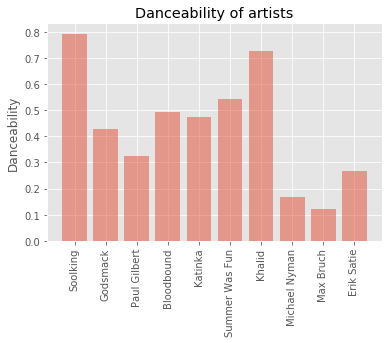

In [16]:
top10 = df[0:10]
objects = top10['artist_name']
y_pos = np.arange(len(objects))
performance = top10['danceability']
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Danceability')
plt.title('Danceability of artists')
plt.xticks(rotation=90)
plt.show()

# 3) Some frequencies of the audio features

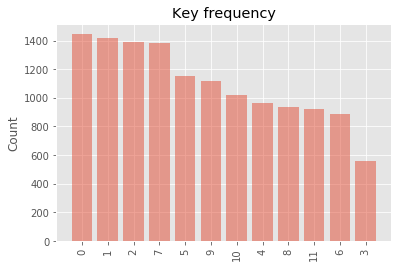

In [23]:
keys = df['key']
dict = {}
for x in keys: 
    if x not in dict: 
        dict[x] = 1
    else:
        dict[x] += 1
        
keyList = list(dict.keys())
keyfreq = list(dict.values())
keyfrequency = pd.DataFrame({'keys' : keyList, 'frequency' : keyfreq} )
keyfrequency.head()

keyfreq = keyfrequency.sort_values('frequency',ascending=False)
objects = keyfreq['keys']
y_pos = np.arange(len(objects))
performance = keyfreq['frequency']
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Count')
plt.title('Key frequency')
plt.xticks(rotation=90)
plt.show()

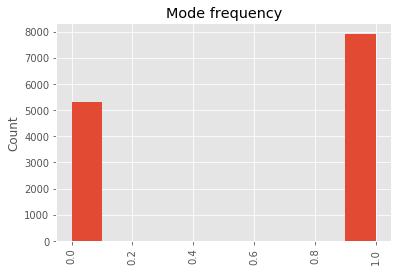

In [19]:
plt.hist(df['mode'])
plt.ylabel('Count')
plt.title('Mode frequency')
plt.xticks(rotation=90)
plt.show()

Given the above plot, it appears that among the top 100 tracks, there are 20 % more songs in major than in minor, which means that there are more "sad" songs than "happy" songs...

# Now, it is time to build our models upon the dataset and with the knowledge that we have now gathered

#### Splitting data into train and test set
The data is split such that 80%  of it will be used to train the models and 20% will be used to test the models.

In [11]:
train_perc = 0.8 # percentage of training data
split_point = int(train_perc*len(y))
perm = np.random.permutation(len(y))
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
ind_train = ind[ix_train]
ind_test = ind[ix_test]
y_train = y[ix_train]
y_test = y[ix_test]
print("Length of training set: %d" % len(y_train))
print("Length of test set: %d" % len(y_test))

Length of training set: 10560
Length of test set: 2640


## Baseline model - Simple Linear Regression

### The generative process:
1. Draw $\sigma \sim \mbox{Cauchy}(50,100)$
2. Draw $Intercept \sim \mathcal{N}(50,100)$
3. For each of the the 13 audio features $d \in \{1,\dots,D\}$  
    1. Draw $\beta_{d} \sim \mathcal{N}(50,100)$
    
    
4. For each track $n=\{1,\dots,N\}$
    1. Draw target popularity $y_n \sim Normal(Intercept+\beta_{d}[ind[n]]' * X[n]',\sigma)$ (where ind[n] collects the correct beta value for the tracks genre) 
     

### The PGM:

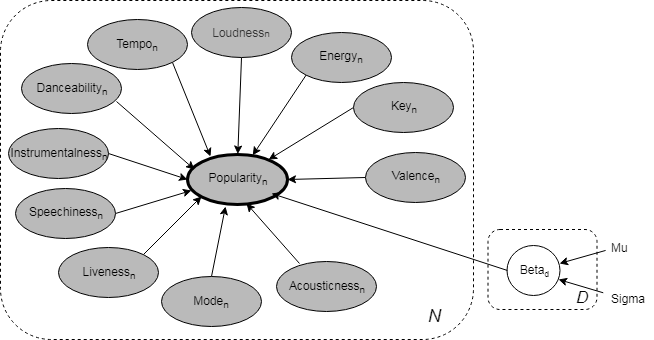

In [7]:
# Vi skal lige opdatere PGM'en på draw.io
Image(filename='PGM_1.PNG')

### The STAN model:

In [8]:
# define Stan model
model_definition_normal = """
data {
    int<lower = 1> N;
    int<lower = 1> D;
    int<lower = 1> C;
    int<lower = 1> I;
    int<lower = 1> ind[N];
    matrix[N,D] X;
    vector<lower=0,upper=C> [N] y;
}

parameters {
    
     
   
    vector[D] beta;               // coefficients for predictors
    real intercept;          // intercept for audio feature for each class
    real<lower=0> sigma;     // variance for each audio feature for each class 
    
}

model {

    sigma ~ cauchy(50,100);
    intercept ~ normal(50,100);
    
    for (d in 1:D){
            beta[d] ~ normal(50,100);
            }

    
    for (n in 1:N){
       y[n] ~ normal(intercept + beta[ind[n]]' * X[n]', sigma); 
       //y[n] ~ categorical(softmax(intercept + beta[ind[n]]' * X[n]'));
    }      
    
}
"""

In [9]:
# prepare data for Stan model
N, D = X_train.shape    # number of obs, number of columns
C = int(y_train.max())  # max popularity rating
I = ind.max()           # max number of genres
print("N=%d, D=%d, C=%d, I=%d" % (N,D,C,I))
data = {'N': N, 'D': D, 'C': C, 'I':I, 'ind':ind_train, 'X': X_train, 'y': y_train}

N=10560, D=13, C=100, I=4


In [10]:
%%time
# create Stan model object
sm = pystan.StanModel(model_code=model_definition_normal)
fit = sm.vb(data=data, iter=10000, algorithm="meanfield", grad_samples=10, seed=42, verbose=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_64e1b5cbb3c4d6b93d68cc717d33439c NOW.
C:\Users\Frederikke\Anaconda3\lib\site-packages\Cython\Compiler\Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\FREDER~1\AppData\Local\Temp\tmp0xbrfdoj\stanfit4anon_model_64e1b5cbb3c4d6b93d68cc717d33439c_2891786284322511948.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
C:\Users\Frederikke\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Wall time: 2min 26s


#### Plotting the beta parameter for each of the audio features (plus intercept) 
$\beta$ parameters is created for each of the audio features, but since each of them are drawn from the same prior distribution, we can't see much variance between the different posterior distributions for $\beta$ in the below plot. 

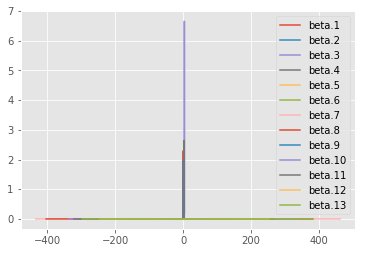

In [11]:
pystan_utils.vb_plot_variables(fit, "beta")

#### Predictions using pystan_utils and model accuracy

In this section the estimated prediction will be calculated and the accuracy will be calculated. Since the model has to predict values between 1-100 it is almost impossible for it to estimate the popularity correctly. The accuracy measure can therefore not be a calculation of how many popularity ratings were predicted correclty for the tracks - the accuracy will always be zero. RMSE and MAE are hence used as metrics for accuracy.  

In [12]:
# get fitted parameters
intercept = pystan_utils.vb_extract_variable(fit, "intercept", var_type="real")
beta = pystan_utils.vb_extract_variable(fit, "beta", var_type="vector", dims=(D))

In [13]:
print("pred: ", np.dot(beta.T, X_test.T).shape)
print("betamatrix: ", beta.T.shape)
print("data: ", X_test.shape)
print("intercepts: ", intercept)

pred:  (2640,)
betamatrix:  (13,)
data:  (2640, 13)
intercepts:  46.70776308299899


In [14]:
def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

In [15]:
# convert back to the original scale
y_hat = intercept + np.dot(beta.T, X_test.T)


print("predictions:", y_hat)
print("true values:", y_test)

preds = y_hat
y_true = y_test 

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))


predictions: [61.07392793 42.76125428 50.7780276  ... 36.43000315 40.60718885
 43.24089787]
true values: [75 64 26 ... 30  2 64]
CorrCoef: 0.411
MAE: 19.918
RMSE: 23.703
R2: 0.164


##### Basine model - resuts

We get an RMSE of approximately 23.7. To illustrate how far the estimated pridiction is from the true popularity, the first 20 observations are shown below. Notice that the model has great difficulty in predicting a popularity of zero.

In [17]:
# Printing the popularity for the test data set
y_true[0:20]

array([75, 64, 26, 69, 49, 35, 64, 28, 67, 61, 48, 23, 65, 10,  0, 40, 63,
       35, 12, 67])

In [18]:
# The predicted popouarity
preds[0:20]

array([61.07392793, 42.76125428, 50.7780276 , 36.75462546, 50.7396118 ,
       48.68413517, 44.14792291, 39.61530755, 60.73277068, 61.19537427,
       62.98623889, 51.48195179, 53.75764095, 44.70238667, 52.20431066,
       33.76703571, 50.75193158, 40.40574306, 39.9287996 , 52.93639617])

#### Comparing the results with the data
In this section we look closer at the intercept and the beta parameter. Each beta value represents the audio features: acousticness, danceability, duration_ms, energy, instrumentalness, key, liveness, loudness, mode, speechiness, tempo, time_signature, valence. We see a that  duration_ms, energy, key, speechiness and valance weighs high in the model.

Furthermore, a visualization of the distribution of the true popularity values (coloured in blue) compared with the predictions (coloured in red) is showed. One can see for the Linear Regression Modelthat predictions follow a Gaussian distribution clustered at the middle of the popularity values.

In [19]:
print("Genre intercepts: ", np.unique(intercept))
print("The beta parameters for each Audio feature: \n", beta)

Genre intercepts:  [46.70776308]
The beta parameters for each Audio feature: 
 [0.7101446  0.98778913 3.96455695 2.90988259 0.34740898 3.71414368
 0.19267364 1.32572462 0.9117209  2.00568865 1.89424566 1.1353546
 3.01961271]


<function matplotlib.pyplot.show(*args, **kw)>

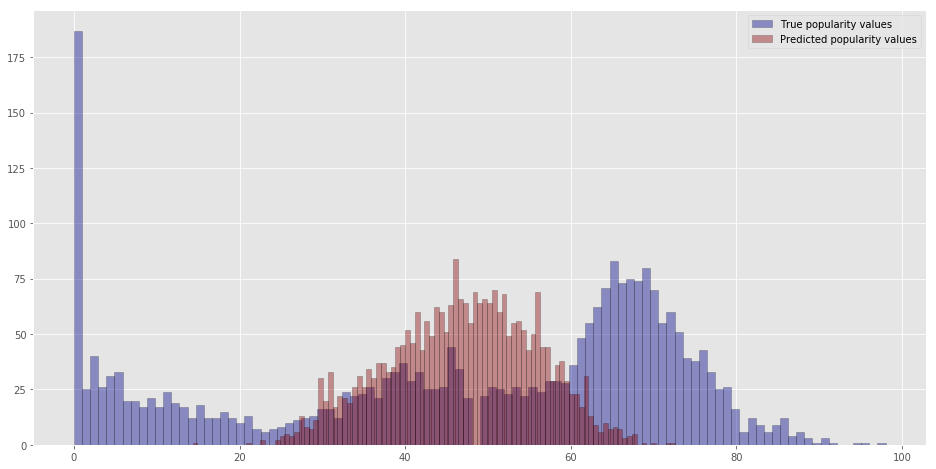

In [16]:
plt.figure(figsize=(16, 8))
true = sns.distplot(y_true, hist=True, kde=False, 
             bins=100, color = 'darkblue', 
             hist_kws={'edgecolor':'black'}, label = 'True popularity values'
             )
pred = sns.distplot(preds, hist=True, kde=False, 
             bins=100, color = 'darkred', 
             hist_kws={'edgecolor':'black'}, label = 'Predicted popularity values'
             )
plt.legend()
plt.show

## Hierachical Regression - Estimating y with a normal distribution in STAN

### The generative process then becomes:

1. For each of the the 13 audio features $d \in \{1,\dots,D\}$  
    1. Draw a global mean parameter $\mu Prior_{d} \sim \mathcal{N}(50,100)$
    2. Draw a global variance parameter $\sigma Prior_{d} \sim \mbox{Cauchy}(50,100)$
    3. For each of the four music genres $i \in \{1,\dots,I\}$
      1. Draw $\beta_{d,i} \sim \mathcal{N}(\mu Prior_{d},\sigma Prior_{d})$
      2. Draw $\sigma_i \sim \mbox{Cauchy}(50,100)$
      3. Draw $Intercept_i \sim \mathcal{N}(50,100)$
    
    
2. For each track $n=\{1,\dots,N\}$
    1. Draw target popularity $y_n \sim Normal(Intercept_{i}+\beta_{d,i}[:,ind[n]]' * X[n]',\sigma_{i}[ind[n]])$ (where ind[n] collects the correct beta value for the tracks genre)

### The PGM:

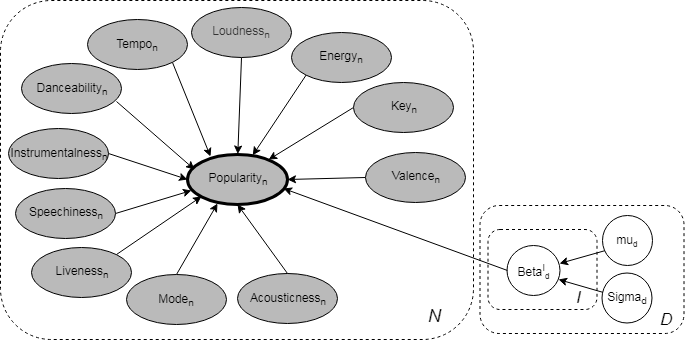

In [20]:
# Vi skal lige opdatere PGM'en på draw.io
Image(filename='PGM_2.PNG')

### The STAN Model:

In [21]:
# define Stan model
model_definition_normal = """
data {
    int<lower = 1> N;
    int<lower = 1> D;
    int<lower = 1> C;
    int<lower = 1> I;
    int<lower = 1> ind[N];
    matrix[N,D] X;
    vector<lower=0,upper=C> [N] y;
}

parameters {
    
     
    vector[D] mu_prior;             // global intercept mean
    vector<lower=0>[D] sigma_prior; // global variance mean
    matrix[D,I] beta;               // coefficients for predictors
    vector[I] intercept;          // intercept for audio feature for each class
    vector<lower=0>[I] sigma;     // variance for each audio feature for each class 
    
}

model {
    for (d in 1:D){
        mu_prior[d] ~ normal(50,100); // Hyper-prior
        sigma_prior[d] ~ cauchy(50,100); // Hyper-prior
        for (i in 1:I) {
            beta[d,i] ~ normal(mu_prior[d],sigma_prior[d]);
            sigma[i] ~ cauchy(50,100);
            intercept[i] ~ normal(50,100);
            }
        }

    
    for (n in 1:N){
        y[n] ~ normal(intercept[ind[n]] + beta[:,ind[n]]' * X[n]', sigma[ind[n]]); 
        //y[n] ~ categorical(softmax(intercept[ind[n]] + beta * X[n]'));
    }      
    
}
"""

In [22]:
# prepare data for Stan model
N, D = X_train.shape    # number of obs, number of columns
C = int(y_train.max())  # max popularity rating
I = ind.max()           # max number of genres
print("N=%d, D=%d, C=%d, I=%d" % (N,D,C,I))
data = {'N': N, 'D': D, 'C': C, 'I':I, 'ind':ind_train, 'X': X_train, 'y': y_train}

N=10560, D=13, C=100, I=4


In [23]:
%%time
# create Stan model object
sm = pystan.StanModel(model_code=model_definition_normal)
fit = sm.vb(data=data, iter=10000, algorithm="meanfield", grad_samples=10, seed=42, verbose=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c2a88ac6db1d917fb3d2ef6be074371f NOW.
C:\Users\Frederikke\Anaconda3\lib\site-packages\Cython\Compiler\Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\FREDER~1\AppData\Local\Temp\tmp_5x0l26b\stanfit4anon_model_c2a88ac6db1d917fb3d2ef6be074371f_6795250234336583926.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
C:\Users\Frederikke\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Wall time: 2min 49s


#### Plotting the beta parameter for each of the audio features (plus intercept) 
$\beta$ parameters is created for each of the audio features and genre, and depends on the hyper priors $\mu_{prior}$ and $\sigma_{prior}$. Since $\beta$ is now created for each level the posterior distribution for $\beta$ varies a great deal more than observered for the simple linear regression model.

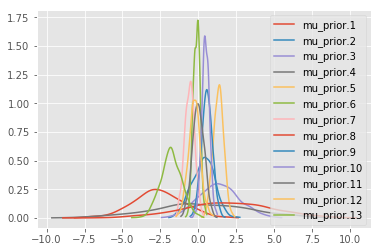

In [24]:
pystan_utils.vb_plot_variables(fit, "mu_prior")

We see that when the hyper prior, $\mu$, is new created for each audio feature, the distribution differs depending on the hyper prior. The same happens to the hyper prior, $\sigma$, shown below.

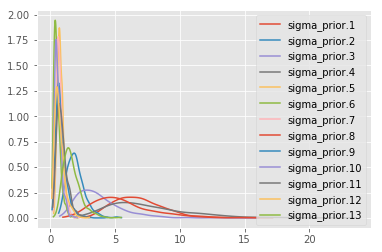

In [25]:
pystan_utils.vb_plot_variables(fit, "sigma_prior")

The $\beta$ parameter will therefore also differ, since it is dependent on each of the hyper priors. In the plot below you see the distributions each $\beta$ value is drawn from. 

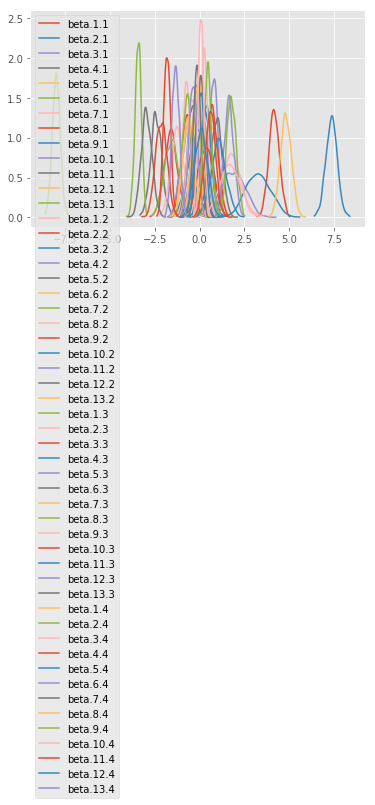

In [26]:
pystan_utils.vb_plot_variables(fit, "beta")

#### Predictions using pystan_utils and model accuracy
We use the same metrics for accuracy as with the baseline linear regression model for comparison.  

In [27]:
# get fitted parameters
mu_prior = pystan_utils.vb_extract_variable(fit, "mu_prior", var_type="vector")
sigma_prior = pystan_utils.vb_extract_variable(fit, "sigma_prior", var_type="vector")
intercept = pystan_utils.vb_extract_variable(fit, "intercept", var_type="vector", dims=(I))
beta = pystan_utils.vb_extract_variable(fit, "beta", var_type="matrix", dims=(D,I))

In [28]:
print("pred: ", np.dot(beta.T, X_test.T).shape)
print("betamatrix: ", beta.T.shape)
print("data: ", X_test.shape)
print("intercepts: ", intercept.shape)

pred:  (4, 2640)
betamatrix:  (4, 13)
data:  (2640, 13)
intercepts:  (4,)


In [29]:
def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

In [30]:
# make predictions for test set
y_hat = []
for i in range(len(intercept)):
        y_hat.append(intercept[i] + np.dot(beta.T, X_test.T)[i])
        
y_hat = np.matrix(y_hat)


#Extracting the right prediction
yhat = np.zeros(y_hat.shape[1])
for n in range(y_hat.shape[1]):
    preds[n] = y_hat[ind_test[n]-1,n]
    

print("predictions:", preds)
print("true values:", y_test)

# True popularity values
y_true = y_test 

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))


predictions: [68.94288277 57.87786749 18.17586282 ... 17.25711847 18.57516213
 65.27716216]
true values: [75 64 26 ... 30  2 64]
CorrCoef: 0.803
MAE: 12.169
RMSE: 15.490
R2: 0.643


#### Hierarchical model - resuts

We get an RMSE of approximately 15.49, which is lower than the simple linear regression - the hierarchical model is predicting better. To illustrate how far the estimated pridiction is from the true popularity, the first 20 observations are shown below. Notice that the model has great difficulty in predicting a popularity of zero.

In [32]:
# Printing the popularity for the test data set
y_true[0:20]

array([75, 64, 26, 69, 49, 35, 64, 28, 67, 61, 48, 23, 65, 10,  0, 40, 63,
       35, 12, 67])

In [33]:
# The predicted popouarity
preds[0:20]

array([68.94288277, 57.87786749, 18.17586282, 60.32205569, 47.92767369,
       15.44800547, 68.96744743, 17.54807992, 66.18692991, 66.70286071,
       46.36886363, 14.88006363, 67.12074455, 14.25526717, 17.0932387 ,
       15.59700279, 59.89695411, 12.85361034, 20.53232861, 62.98547445])

### Comparing the results with the data

In this section we look closer at the intercept and the beta parameter. In beta matrix are the columns representing the genres and the rows representing the audio features. 

- The columns represent the genre: Pop, Metal, Classical, Rap. 

- The rows represent the audio features: acousticness, danceability, duration_ms, energy, instrumentalness, key, liveness, loudness, mode, speechiness, tempo, time_signature, valence.

Furthermore, the a visualization of the distribution of the true popularity values (coloured in blue) compared with the predictions (coloured in red) is shown. One can see for the Linear Regression Model that predictions follow a Gaussian distribution with clusters at both the lower and higher end of popularity values.

In [34]:
print("Genre intercepts: ", np.unique(intercept[ind_test-1]))
print("The beta parameters for each genre and Audio feature: \n", beta)

Genre intercepts:  [28.73001768 61.79380251 62.28683052 63.94098003]
The beta parameters for each genre and Audio feature: 
 [[-1.62196864 -1.24048961 -8.00696394 -0.19409146]
 [-0.29098842 -0.71860348  0.27723534  1.78928629]
 [ 1.88119202  3.27312575 -1.82967456  1.71167702]
 [-2.42004639 -0.69070316  7.37026681 -2.14336631]
 [ 0.70589656  0.94033971  1.65537453  1.04807353]
 [ 0.18133261 -0.08032576  0.05077319 -0.37235589]
 [-0.75191482 -0.71235817 -0.62013737 -0.13994001]
 [ 4.14598512  1.82365453 -3.42613254  4.82315211]
 [ 0.40720646  0.73751224 -0.40245486  0.43722222]
 [ 0.78754175  0.33611696  0.32530603  0.07360116]
 [-0.13278574  0.01124344  0.03212101  0.5883693 ]
 [-0.349298   -0.41172662 -0.19300617  0.08119563]
 [-1.56467323 -0.64111468 -2.96387736 -1.34617234]]


<function matplotlib.pyplot.show(*args, **kw)>

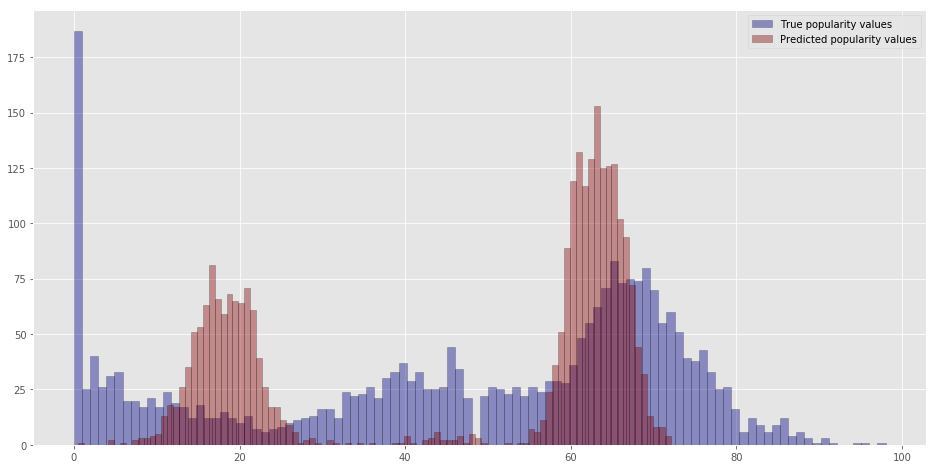

In [31]:
plt.figure(figsize=(16, 8))
true = sns.distplot(y_true, hist=True, kde=False, 
             bins=100, color = 'darkblue', 
             hist_kws={'edgecolor':'black'}, label = 'True popularity values'
             )
pred = sns.distplot(preds, hist=True, kde=False, 
             bins=100, color = 'darkred', 
             hist_kws={'edgecolor':'black'}, label = 'Predicted popularity values'
             )
plt.legend()
plt.show

## 2nd Model - Hierarchical Regression in STAN (not finished)

### The generative process then becomes:

1. For each of the the 13 audio features $d \in \{1,\dots,D\}$  
    1. Draw a global mean parameter $\mu Prior_{d} \sim \mathcal{N}(0,10)$
    2. Draw a global variance parameter $\sigma Prior_{d} \sim \mbox{Cauchy}(0,10)$
    3. For each of the four music genres $i \in \{1,\dots,I\}$
      1. Draw $\beta_{d,i} \sim \mathcal{N}(\mu Prior_{d},\sigma Prior_{d})$
      2. Draw $\sigma_i \sim \mathcal{N}(0,10)$
      3. Draw $Intercept_i \sim \mathcal{N}(0,10)$
    
    
2. For each track $n=\{1,\dots,N\}$
      1. Draw target popularity $y_n \sim beta(\exp(Intercept_{i}+\beta1_{d,i}[:,ind[n]]' * X[n]'),\exp(Intercept_{i}+\beta1_{d,i}[:,ind[n]]' * X[n]'))$ (where ind[n] collects the correct beta value for the tracks genre



### The STAN Model:

In [35]:
# define Stan model
model_definition_beta = """
data {
    int<lower = 1> N;
    int<lower = 1> D;
    int<lower = 1> C;
    int<lower = 1> I;
    int<lower = 1> ind[N];
    matrix[N,D] X;
    int<lower=0,upper=C> y[N];
}

parameters {
    
     
    vector[D] mu_prior;                    // global intercept mean
    vector<lower=0>[D] sigma_prior;        // global variance mean
    matrix[D,I] beta1;            // coefficients for predictors
    matrix[D,I] beta2;            // coefficients for predictors
    vector[I] intercept1;         // intercept for audio feature for each class
    vector[I] intercept2;         // intercept for audio feature for each class
    vector[N] mu;
    vector[N] phi;
    real A;
    real B;
}

model {
    
    for (d in 1:D){
        mu_prior[d] ~ normal(50,100);      // Hyper-prior
        print(mu_prior[d])
        sigma_prior[d] ~ cauchy(50,100);   // Hyper-prior
        for (i in 1:I) {
            beta1[d,i] ~ normal(mu_prior[d],sigma_prior[d]);
            beta2[d,i] ~ normal(mu_prior[d],sigma_prior[d]);
            intercept1[i] ~ normal(50,100);
            intercept2[i] ~ normal(50,100);
            }
        }
 
    for (n in 1:N) {
        mu[n]=inv_logit(beta1[:,ind[n]]*X[n,:]);   
        phi[n]=exp(X[n,]);
    }

    A = mu .* phi;
    B = (1.0 - mu) .* phi;
    
    for (n in 1:N){
        
        y[n] ~ beta(A, B);
    
    //for (n in 1:N){
      //  y[n] ~ beta(exp(intercept1[ind[n]] + beta1[:,ind[n]]' * X[n]'), exp(intercept2[ind[n]] + beta2[:,ind[n]]' * X[n]'));
        
        
    }    
}
"""

Prepare input data for STAN, compile STAN program and run inference using ADVI (much faster in this case):

In [36]:
# prepare data for Stan model
N, D = X_train.shape    # number of obs, number of columns
C = int(y_train.max())  # max popularity rating
I = ind.max()           # max number of genres
print("N=%d, D=%d, C=%d, I=%d" % (N,D,C,I))
data = {'N': N, 'D': D, 'C': C, 'I':I, 'ind':ind_train, 'X': X_train, 'y': y_train}

N=10560, D=13, C=100, I=4


In [37]:
print(np.min(X_train))
print(np.argmin(X_train, axis=0))

X_train[30,]

-7.201251843022332
[4821  337 5661 1784   16    3 4935 3799    1  337  337  337  337]


array([ 1.19168949, -0.58490057, -0.31716462, -1.43725838,  1.60784955,
        1.07843767, -0.8010872 , -2.19710511, -1.2230069 , -0.5287473 ,
        0.65300409, -1.58911375, -1.20952476])

In [38]:
%%time
# create Stan model object
sm = pystan.StanModel(model_code=model_definition_beta)
fit = sm.vb(data=data, iter=10000, algorithm="meanfield", grad_samples=10, seed=42, verbose=True)

ValueError: Failed to parse Stan model 'anon_model_256565333432734d6988e2906a443b60'. Error message:
SYNTAX ERROR, MESSAGE(S) FROM PARSER:

Cannot assign to variable outside of declaration block; left-hand-side variable origin=parameter
  error in 'unknown file name' at line 42, column 15
  -------------------------------------------------
    40:  
    41:     for (n in 1:N) {
    42:         mu[n]=inv_logit(beta1[:,ind[n]]*X[n,:]);   
                      ^
    43:         phi[n]=exp(X[n,]);
  -------------------------------------------------

PARSER EXPECTED: <expression assignable to left-hand side>


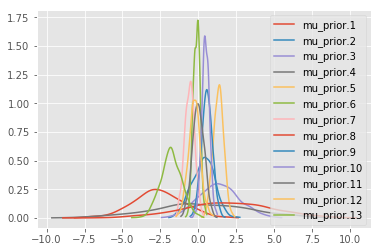

In [39]:
pystan_utils.vb_plot_variables(fit, "mu_prior")

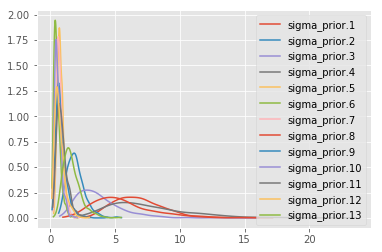

In [40]:
pystan_utils.vb_plot_variables(fit, "sigma_prior")

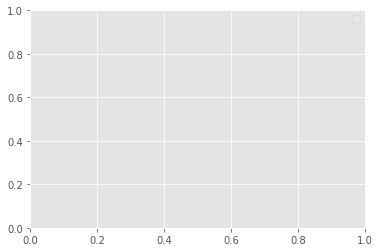

In [41]:
pystan_utils.vb_plot_variables(fit, "beta1")

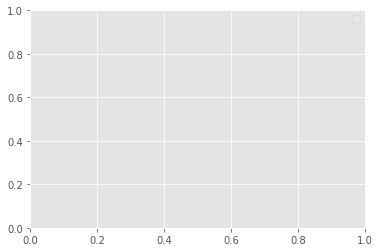

In [42]:
pystan_utils.vb_plot_variables(fit, "beta2")

#### Predictions using pystan_utils

In [43]:
# get fitted parameters
mu_prior = pystan_utils.vb_extract_variable(fit, "mu_prior", var_type="vector")
sigma_prior = pystan_utils.vb_extract_variable(fit, "sigma_prior", var_type="vector")
intercept1 = pystan_utils.vb_extract_variable(fit, "intercept1", var_type="vector", dims=(I))
intercept2 = pystan_utils.vb_extract_variable(fit, "intercept2", var_type="vector", dims=(I))
beta1 = pystan_utils.vb_extract_variable(fit, "beta1", var_type="matrix", dims=(D,I))
beta2 = pystan_utils.vb_extract_variable(fit, "beta2", var_type="matrix", dims=(D,I))

ValueError: cannot reshape array of size 0 into shape (13,4)

Using expected values of the parameters, we can make predictions for the testset. However, we need to account for the fact that we now have different bias parameters per track. 

In [ ]:
# make predictions for test set
y_hat = alpha[:,ind_test-1] + np.dot(beta, X_test.T)
y_hat = np.argmax(y_hat, axis=0) + 1
print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))

In [ ]:
print(y_hat[0:20])